# Import

In [1]:
import pandas as pd
import os
from os.path import join
from datetime import datetime, timezone, timedelta
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from yforseer.networks import StockNet
from yforseer.datasets import StockDataset, StockDiffDataset
from yforseer.trainers import StockNetTrainer
from tqdm import tqdm
from yforseer.scraping import RawDF_Schema
from yforseer.utils import convert_diff_to_prices
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = 'cpu'
device = torch.device(dev)
print('Device %s is used '%(device))

Device cpu is used 


# Dataset and loader

In [2]:

# Load dataset
load_array_pth = 'data/yahoo/artifacts/data_array.npz'
loaded_data = np.load(load_array_pth)
data = torch.from_numpy(loaded_data['data']).to(torch.float32)
mu, std = loaded_data['mu'], loaded_data['std']
num_days = data.shape[1]
test_size = int(0.1 * num_days)
train_size = num_days - test_size
train_data = data[:, :train_size]
test_data = data[:, train_size:]
train_dataset = StockDiffDataset(data = train_data, memory=60)
test_dataset = StockDiffDataset(data = test_data, memory=60)
print('train_dataset:', len(train_dataset))
print('test_dataset:', len(test_dataset))


train_dataset: 5318
test_dataset: 537


# Colab training script

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from yforseer.datasets import StockDataset, StockDiffDataset
from yforseer.trainers import StockTCNNTrainer
from yforseer.evaluate import evaluate_stock_trend_prediction
from yforseer.utils import convert_diff_to_prices
from tqdm import tqdm
import matplotlib.pyplot as plt
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = 'cpu'
device = torch.device(dev)
print('Device %s is used '%(device))

Device cpu is used 


In [2]:
batch_size = 32
epochs = 100
lr = 0.001
test_frac = 0.1
# memory = 60
memory = 120
lookahead = 1


# Load data
load_array_pth = 'data/yahoo/artifacts/data_array.npz'
loaded_data = np.load(load_array_pth)
data = torch.from_numpy(loaded_data['data']).to(torch.float32)
mu, std = loaded_data['mu'].item(), loaded_data['std'].item()
print(data.shape)


# Datasets and dataloaders
num_days = data.shape[1]
test_size = int(test_frac * num_days)
train_size = num_days - test_size
train_data = data[:, :train_size]
test_data = data[:, train_size:]
# train_dataset = StockDataset(data = train_data, memory=memory, lookahead=lookahead, mode='last')
# test_dataset = StockDataset(data = test_data, memory=memory, lookahead=lookahead, mode='last')
train_dataset = StockDiffDataset(data = train_data, memory=memory, lookahead=lookahead)
test_dataset = StockDiffDataset(data = test_data, memory=memory, lookahead=lookahead)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print('train_dataset:', len(train_dataset))
print('test_dataset:', len(test_dataset))

# Train
num_channels = [128, 256, 512, 256, 128]
# num_channels = [128, 128]
trainer = StockTCNNTrainer(lr = lr, input_size=71, output_size=71, num_channels=num_channels, kernel_size=6, dropout=0.1)
trainer.model.to(device)
all_accs = []
top1_breturns, top3_breturns, all_breturns = [], [], []
top1_breturns_up, top3_breturns_up, all_breturns_up = [], [], []


all_test_loss, all_train_loss = [], []
for epoch in (bar := tqdm(range(epochs))):
    train_loss_list, test_loss_list = [], []
    trainer.model.train()
    for Xdiff_train, ydiff_train, _, _ in train_dataloader:
        train_loss, _ = trainer.train(Xdiff_train.to(device), ydiff_train.to(device))
        train_loss_list.append(train_loss)
    all_train_loss.append(np.mean(train_loss_list))

    trainer.model.eval()
    all_x_test = []
    all_y_pred = []
    all_y_test = []
    # all_prices_test = []
    for Xdiff_test, ydiff_test, Xprices_test, yprice_test in test_dataloader:
        test_loss, y_pred = trainer.test(Xdiff_test.to(device), ydiff_test.to(device))
        

        test_loss_list.append(test_loss)
        yprice_pred_test = Xprices_test[:, :, [-1]] + y_pred.cpu().detach()

        all_x_test.append(Xprices_test.cpu().detach().numpy())
        all_y_pred.append(yprice_pred_test.cpu().detach().numpy().squeeze())
        all_y_test.append(yprice_test.cpu().detach().numpy().squeeze())


    all_test_loss.append(np.mean(test_loss_list))

    all_x_test = np.concatenate(all_x_test, axis=0)
    all_y_pred = np.concatenate(all_y_pred, axis=0)
    all_y_test = np.concatenate(all_y_test, axis=0)
    all_x_test = all_x_test * std + mu
    all_y_pred = all_y_pred * std + mu
    all_y_test = all_y_test * std + mu
    (trend_acc, rise_acc, drop_acc), buy_returns, _ = evaluate_stock_trend_prediction(all_x_test[:, :, -1], all_y_pred, all_y_test)
    all_accs.append(trend_acc)
    top1_breturns.append(buy_returns[0][:, 0])
    top3_breturns.append(buy_returns[0][:, 1])
    all_breturns.append(buy_returns[0][:, 2])
    top1_breturns_up.append(buy_returns[1][:, 0])
    top3_breturns_up.append(buy_returns[1][:, 1])
    all_breturns_up.append(buy_returns[1][:, 2])

    bar.set_description(f'ACC={np.nanmedian(trend_acc):0.4f}, Breturns={np.nanmedian(buy_returns[0][:, 2]):0.4f}, test_lose={all_test_loss[-1]:0.4f}, train_loss={all_train_loss[-1]:0.4f}')

    # Log prediction
    np.savez('predictions.npz', x_test=all_x_test, y_pred=all_y_pred, y_test=all_y_test)

all_accs = np.stack(all_accs)
top1_breturns = np.stack(top1_breturns)
top3_breturns = np.stack(top3_breturns)
all_breturns = np.stack(all_breturns)
top1_breturns_up = np.stack(top1_breturns_up)
top3_breturns_up = np.stack(top3_breturns_up)
all_breturns_up = np.stack(all_breturns_up)


torch.Size([71, 5975])
train_dataset: 5258
test_dataset: 477


ACC=0.5070, Breturns=0.0010, test_lose=0.0007, train_loss=0.0009:   3%|▎         | 3/100 [01:12<38:50, 24.02s/it]


KeyboardInterrupt: 

# Load model and evaluate

In [27]:
from yforseer.trainers import StockTCNNTrainer

lr = 0.0001
num_channels = [128, 256, 512, 256, 128]
trainer = StockTCNNTrainer(lr = lr, input_size=71, output_size=71, num_channels=num_channels, kernel_size=6, dropout=0.1)
trainer.model.to(device)
trainer.load('data/model.pth')


/mnt/yforseer/trainers.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pth)


In [3]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train, y_train, y_pred_train = [], [], []
X_test, y_test, y_pred_test = [], [], []

trainer.model.eval()



for Xdiff_train, ydiff_train, Xprices_train, yprice_train in train_dataloader:
    test_loss, y_pred = trainer.test(Xdiff_train.to(device), ydiff_train.to(device))
    test_loss_list.append(test_loss)
    yprice_pred_train = Xprices_train[:, :, [-1]] + y_pred.cpu().detach()
    X_train.append(Xprices_train.cpu().detach().numpy())
    y_pred_train.append(yprice_pred_train.cpu().detach().numpy().squeeze())
    y_train.append(yprice_train.cpu().detach().numpy().squeeze())


for Xdiff_test, ydiff_test, Xprices_test, yprice_test in test_dataloader:
    _, y_pred = trainer.test(Xdiff_test.to(device), ydiff_test.to(device))
    test_loss_list.append(test_loss)
    yprice_pred_test = Xprices_test[:, :, [-1]] + y_pred.cpu().detach()
    X_test.append(Xprices_test.cpu().detach().numpy())
    y_pred_test.append(yprice_pred_test.cpu().detach().numpy().squeeze())
    y_test.append(yprice_test.cpu().detach().numpy().squeeze())

    

X_train = np.concatenate(X_train, axis=0)  * std + mu
y_train = np.concatenate(y_train, axis=0).squeeze() * std + mu
y_pred_train = np.concatenate(y_pred_train, axis=0).squeeze() * std + mu
X_test = np.concatenate(X_test, axis=0)  * std + mu
y_test = np.concatenate(y_test, axis=0).squeeze() * std + mu
y_pred_test = np.concatenate(y_pred_test, axis=0).squeeze() * std + mu


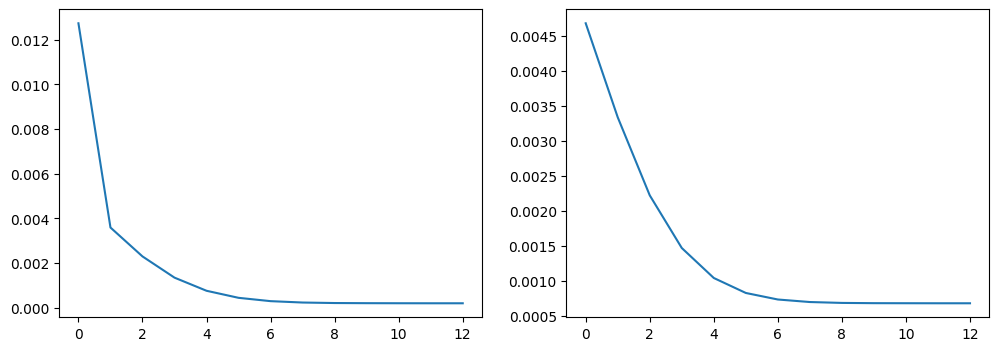

In [6]:
# Loss
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(all_train_loss)
ax[1].plot(all_test_loss)


Text(0.5, 1.0, 'Null=18.2961, Target=18.3512')

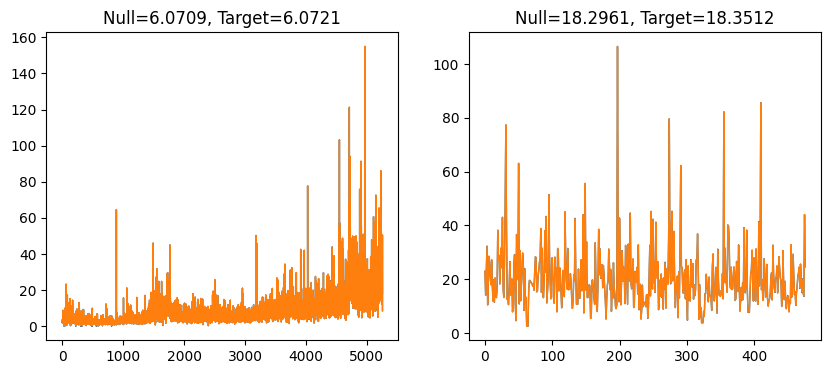

In [5]:
MSE_null_train = np.sqrt(np.square(y_train - X_train[:, :, -1]).mean(axis=1))
MSE_target_train = np.sqrt(np.square(y_train - y_pred_train).mean(axis=1))
MSE_null_test = np.sqrt(np.square(y_test - X_test[:, :, -1]).mean(axis=1))
MSE_target_test = np.sqrt(np.square(y_test - y_pred_test).mean(axis=1))


fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(MSE_null_train, label='null, train', linewidth=1)
ax[0].plot(MSE_target_train, label='target, train', linewidth=1)
ax[0].set_title(f'Null={np.median(MSE_null_train):0.4f}, Target={np.median(MSE_target_train):0.4f}')
ax[1].plot(MSE_null_test, label='null, test', linewidth=1)
ax[1].plot(MSE_target_test, label='target, test', linewidth=1)
ax[1].set_title(f'Null={np.median(MSE_null_test):0.4f}, Target={np.median(MSE_target_test):0.4f}')

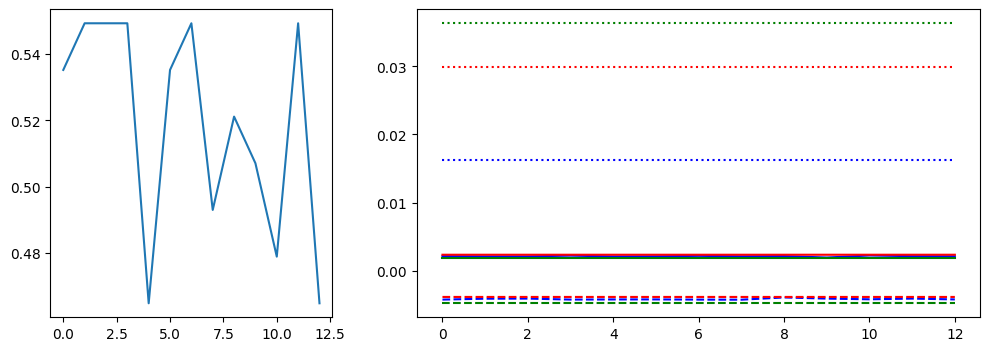

In [7]:
# Accuracies and returns
fig, ax = plt.subplots(1, 2, figsize=(12, 4), width_ratios=[1, 2])
ax[0].plot(np.median(all_accs, axis=1))

ax[1].plot(np.nanmedian(all_breturns, axis=1), c='b')
ax[1].plot(np.nanmedian(top1_breturns, axis=1), c='g')
ax[1].plot(np.nanmedian(top3_breturns, axis=1), c='r')
ax[1].plot(np.nanquantile(all_breturns, 0.25, axis=1), linestyle='--', c='b')
ax[1].plot(np.nanquantile(top1_breturns, 0.25, axis=1), linestyle='--', c='g')
ax[1].plot(np.nanquantile(top3_breturns, 0.25, axis=1), linestyle='--', c='r')

ax[1].plot(np.nanmedian(all_breturns_up, axis=1), linestyle=':', c='b')
ax[1].plot(np.nanmedian(top1_breturns_up, axis=1), linestyle=':', c='g')
ax[1].plot(np.nanmedian(top3_breturns_up, axis=1), linestyle=':', c='r')


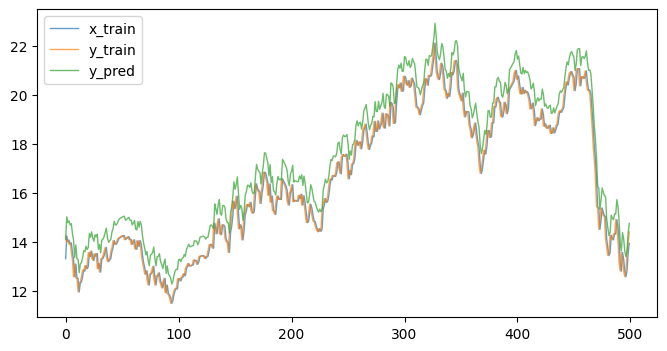

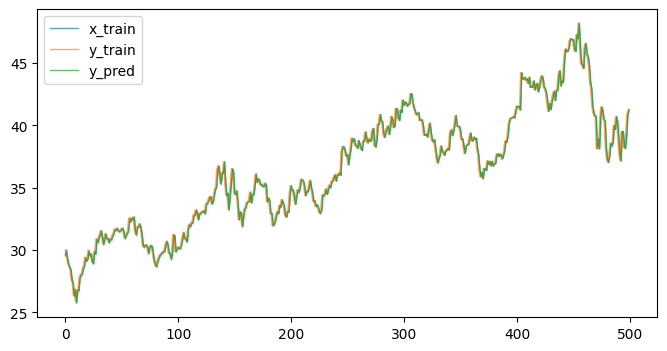

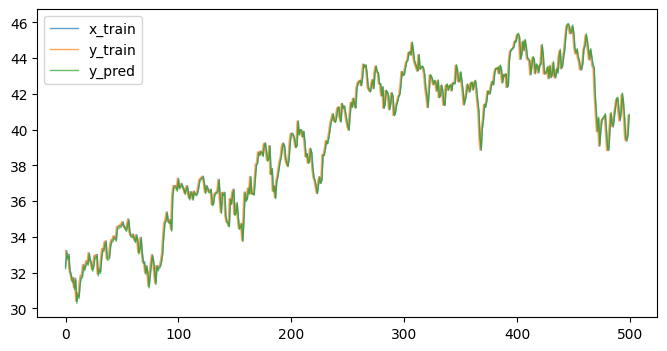

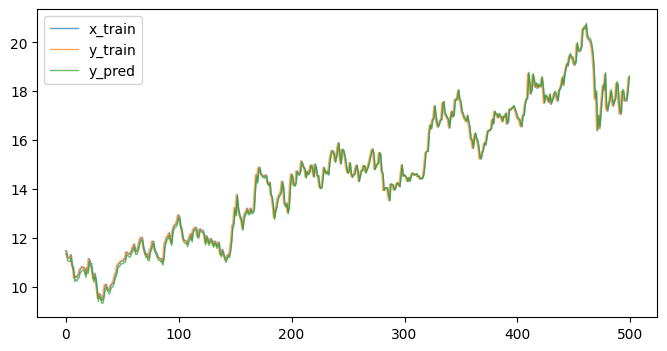

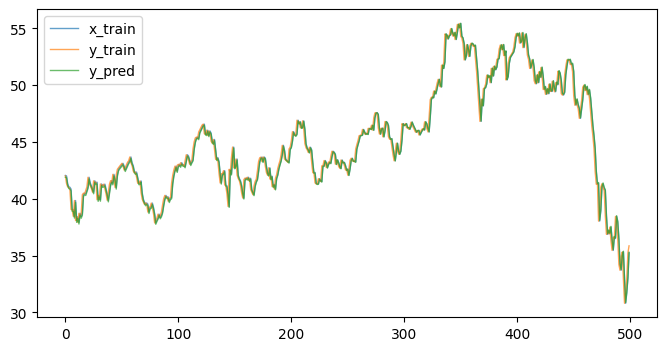

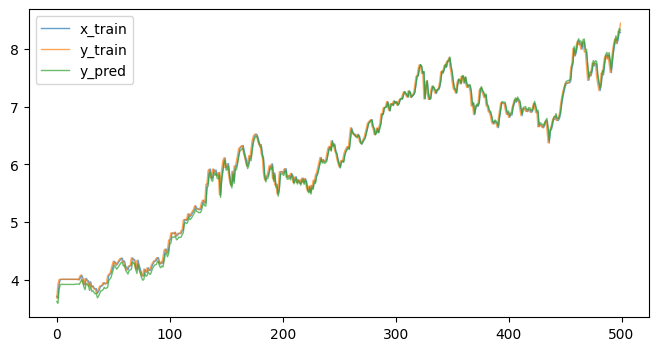

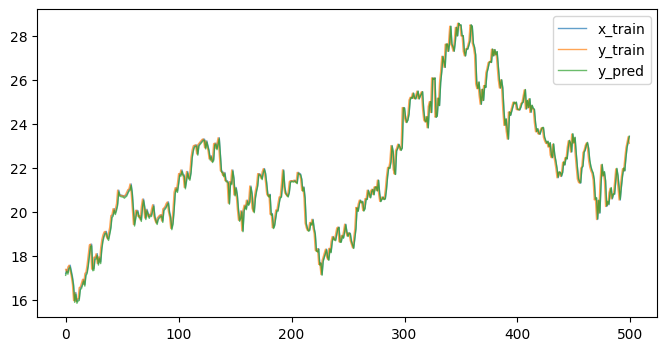

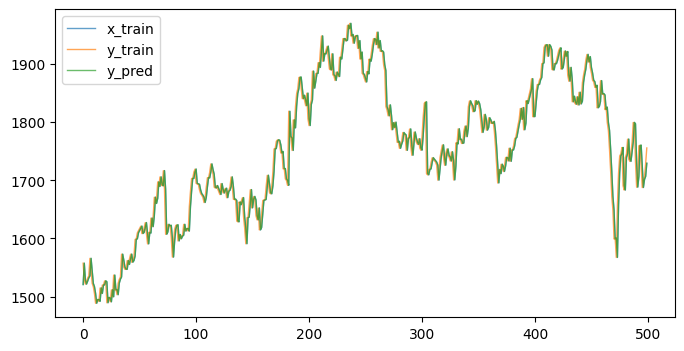

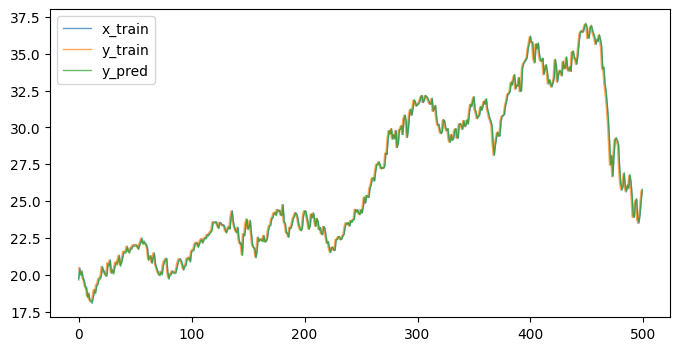

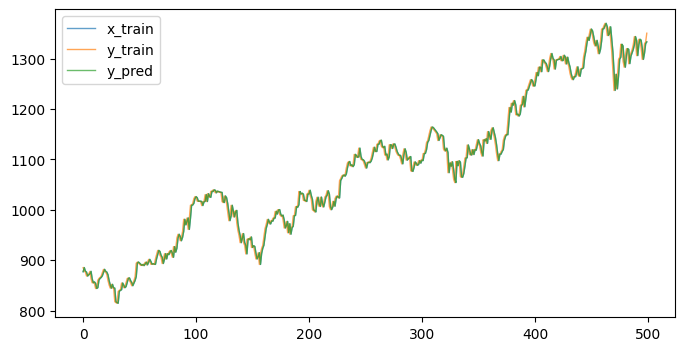

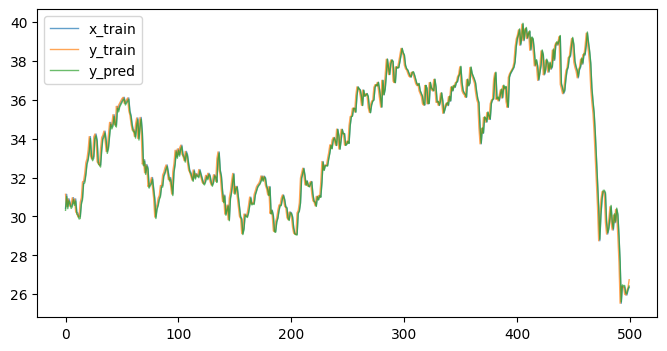

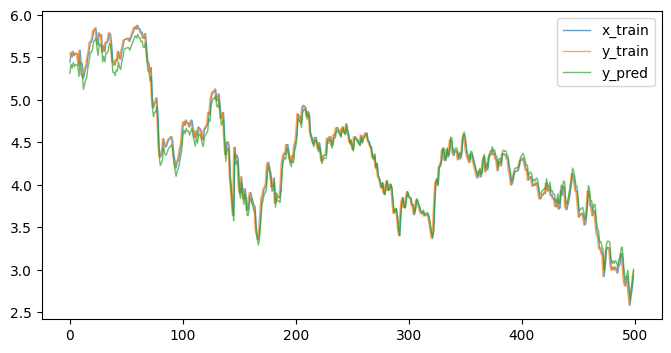

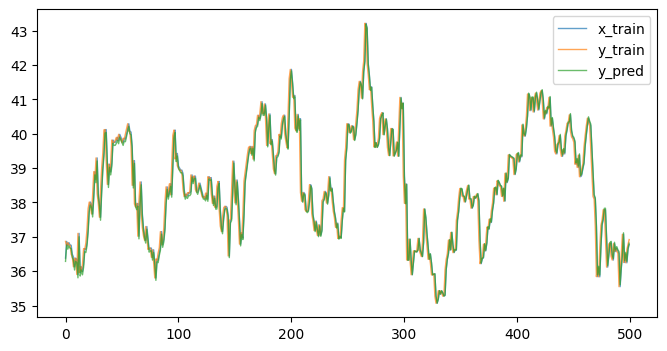

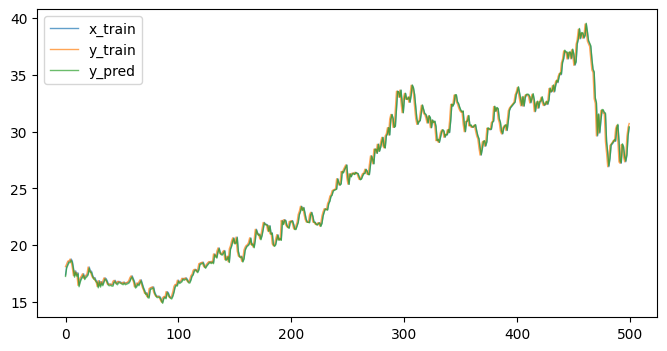

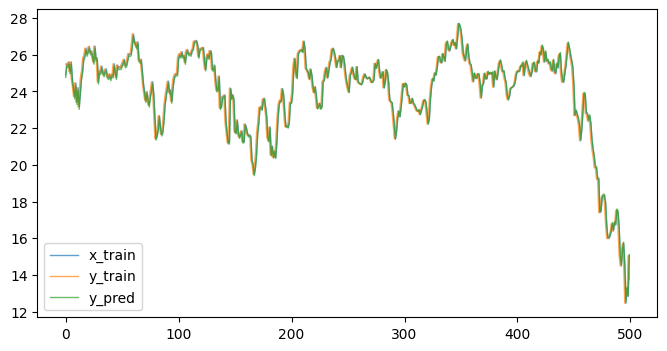

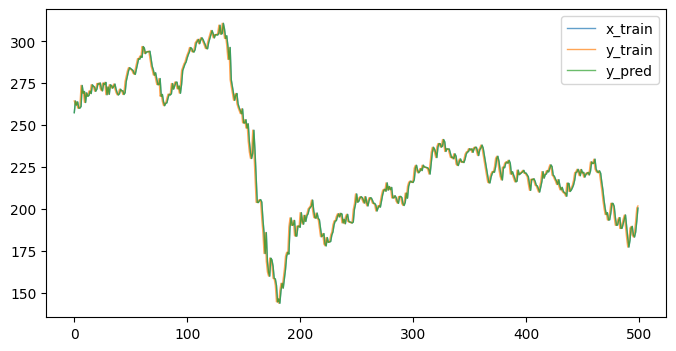

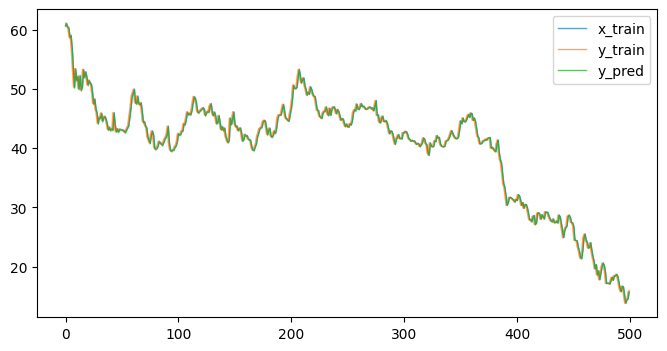

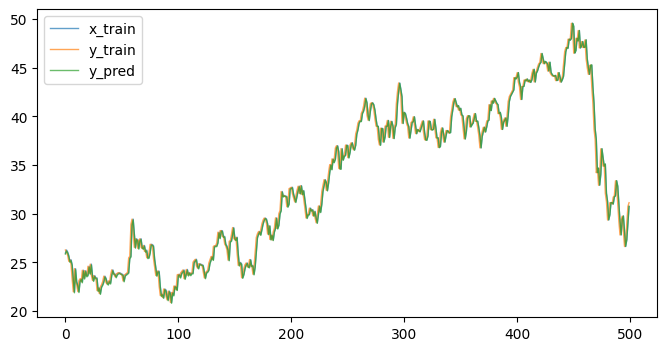

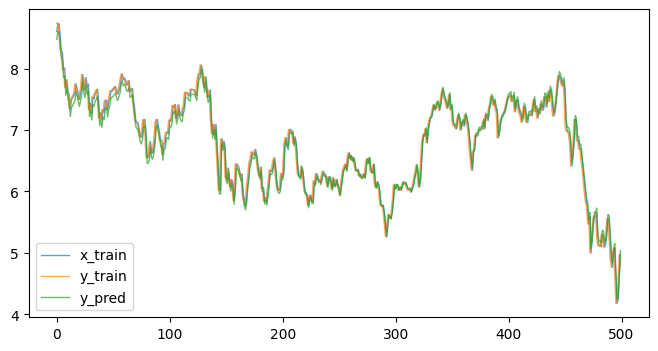

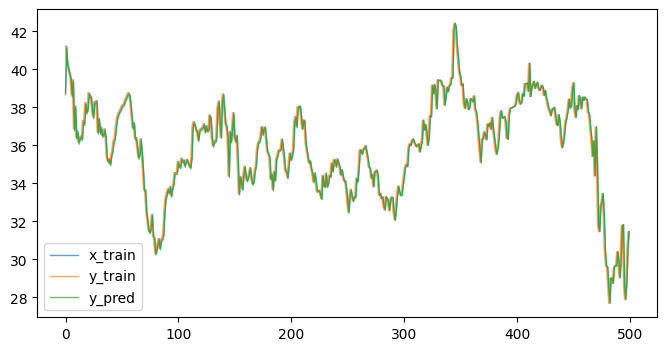

In [8]:
i1, i2 = 2000, 2500
for j in range(20):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(x_train[i1:i2, j, -1], label='x_train', alpha=0.7, linewidth=1)
    ax.plot(y_train[i1:i2, j], label='y_train', alpha=0.7, linewidth=1)
    ax.plot(y_pred_train[i1:i2, j], label='y_pred', alpha=0.7, linewidth=1)

    ax.legend()

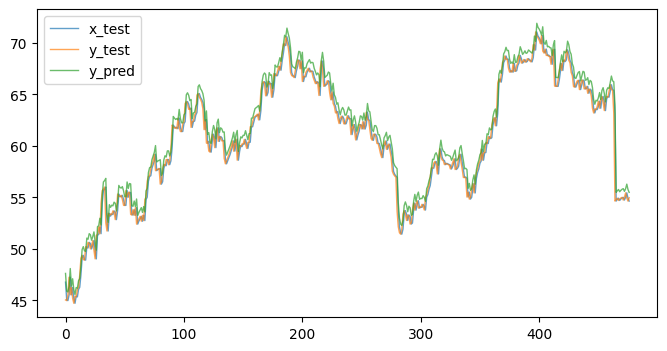

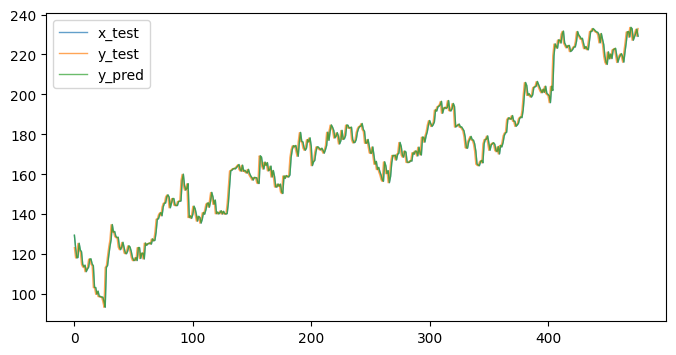

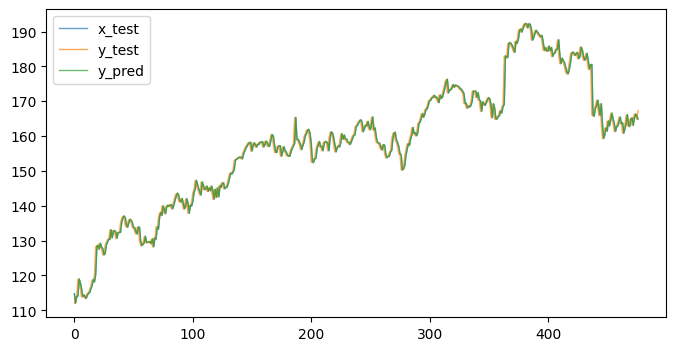

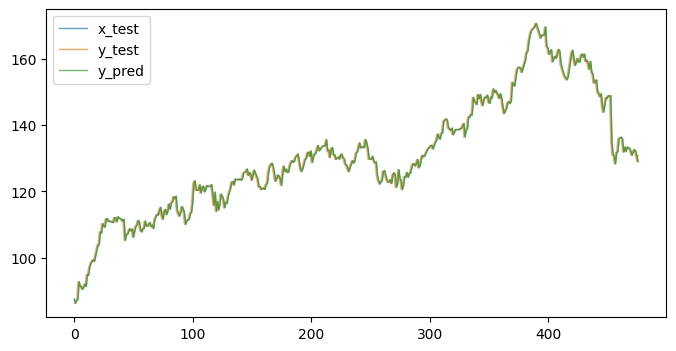

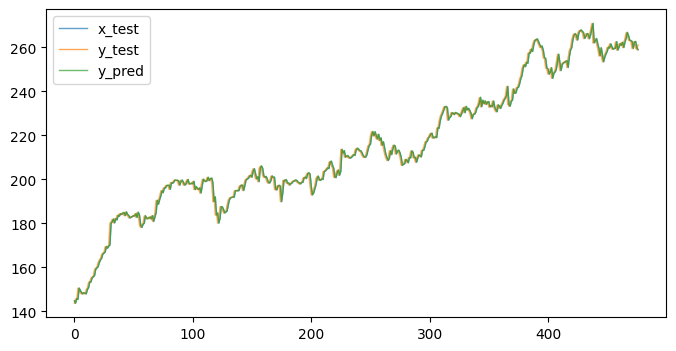

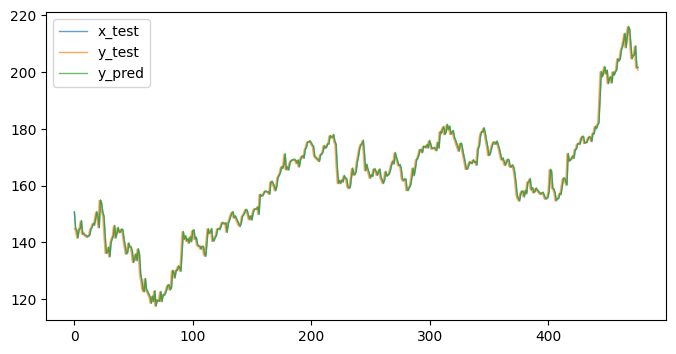

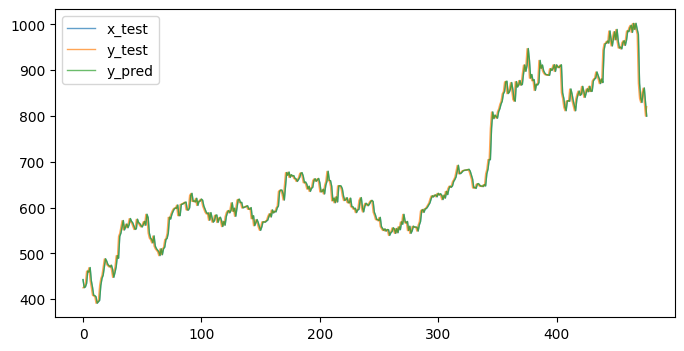

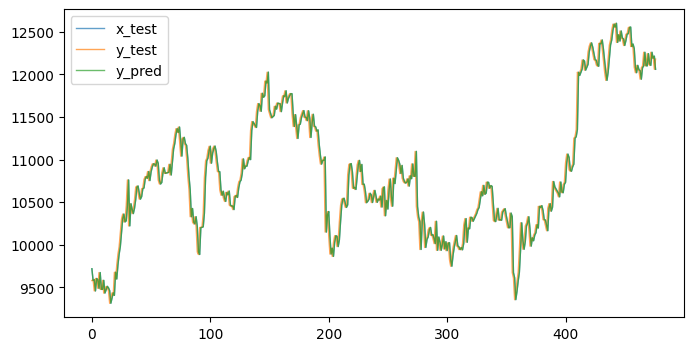

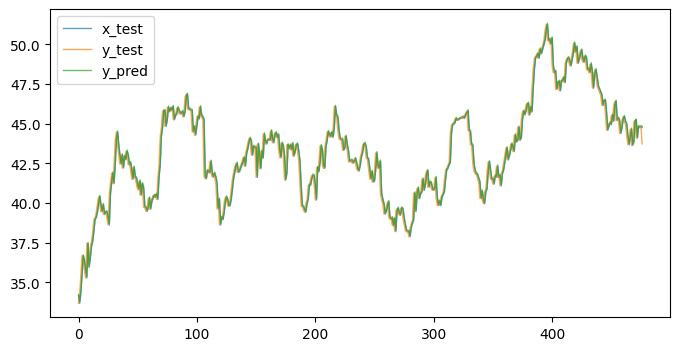

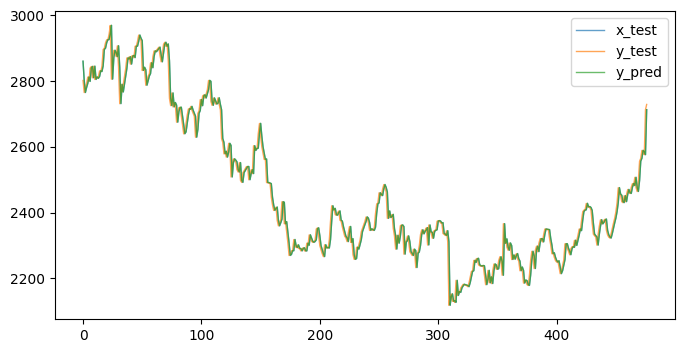

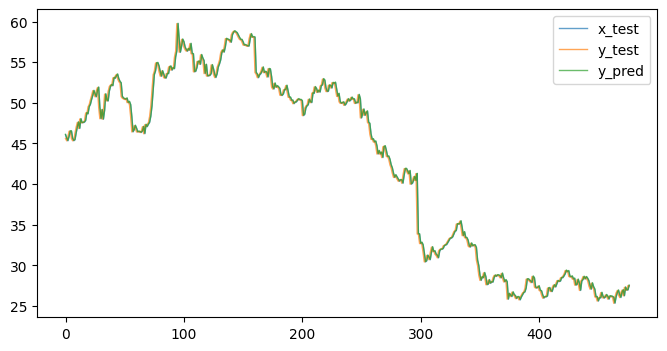

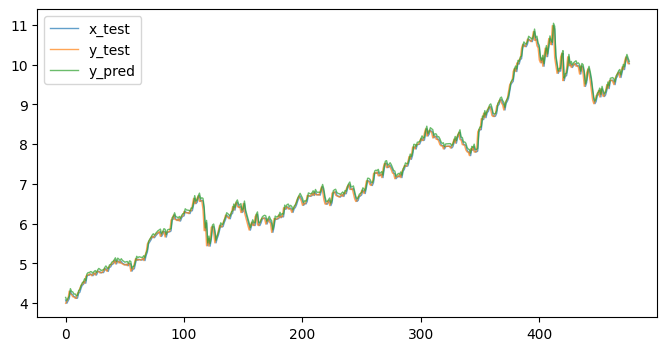

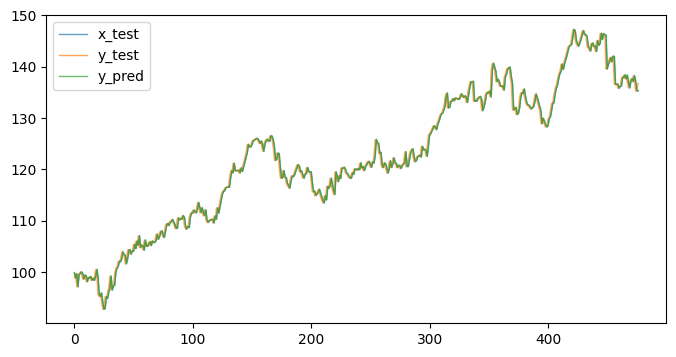

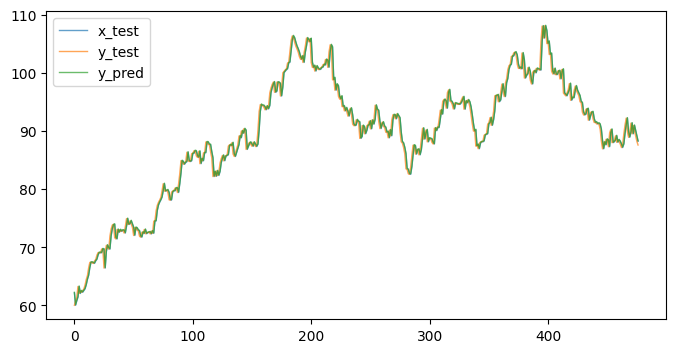

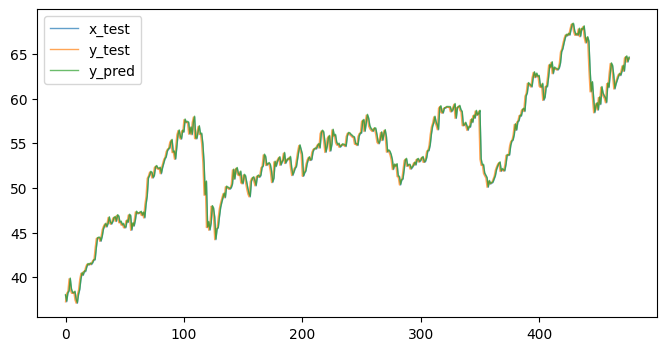

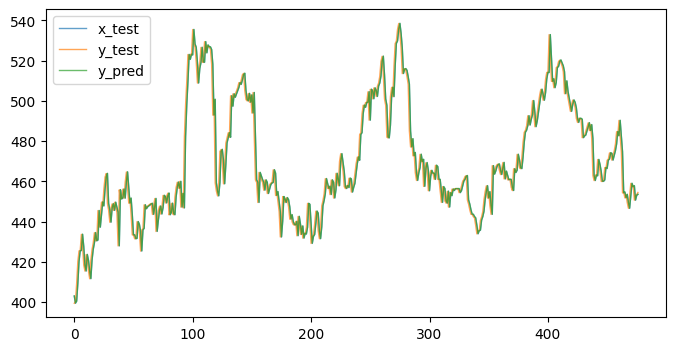

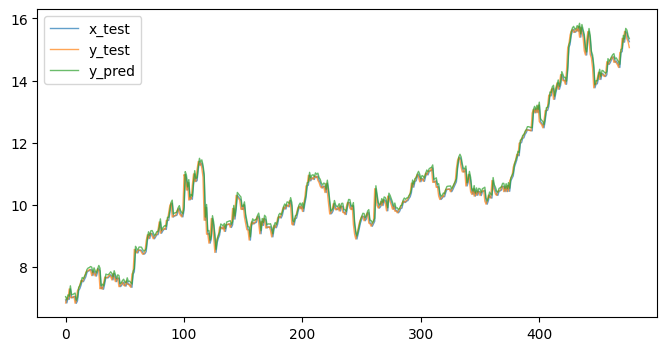

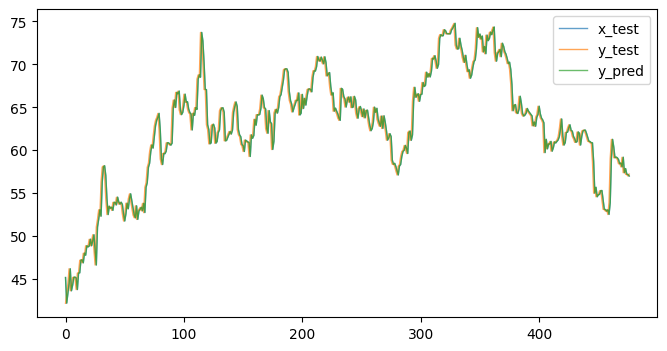

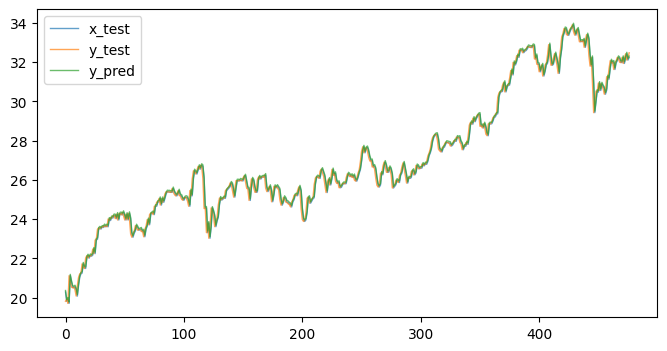

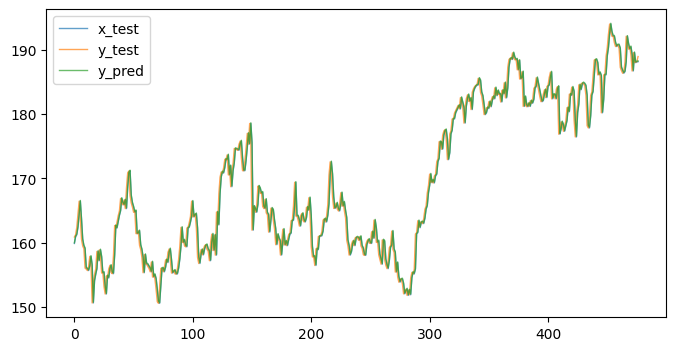

In [9]:
T = 500
for j in range(20):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(x_test[:T, j, -1], label='x_test', alpha=0.7, linewidth=1)
    ax.plot(y_test[:T, j], label='y_test', alpha=0.7, linewidth=1)
    ax.plot(y_pred_test[:T, j], label='y_pred', alpha=0.7, linewidth=1)

    ax.legend()

# ARIMA

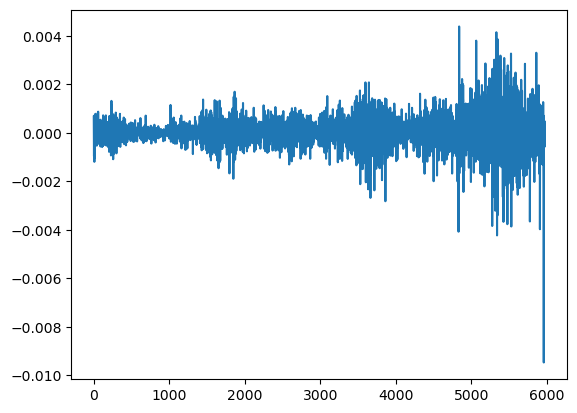

In [74]:
x = loaded_data['data'][0, :]

xdiff = np.diff(x)

plt.plot(xdiff)

In [75]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(xdiff)

print(result)


(-19.293123510921372, 0.0, 16, 5957, {'1%': -3.431448223954974, '5%': -2.8620253133941227, '10%': -2.5670283299556957}, -71401.6441751672)


In [77]:
result[1]

0.0

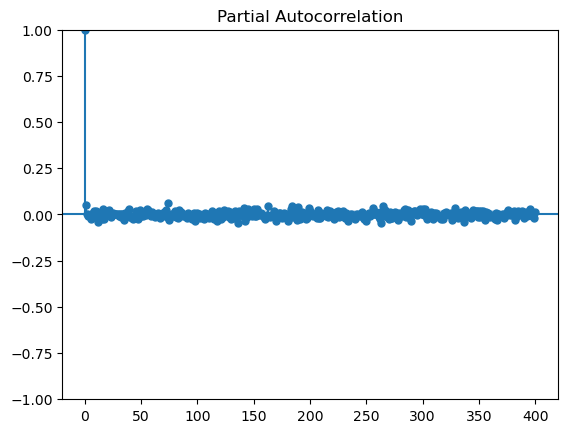

In [82]:
%matplotlib qt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_pacf(xdiff, lags=400)

In [87]:
x.shape[0]-365

5610

In [102]:
from statsmodels.tsa.arima.model import ARIMA
train_size = 5610
test_size = 365
x_train = x[:train_size]
x_test = x[train_size:train_size+test_size]
model = ARIMA(x_train, order=(30, 1, 0))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5610
Model:                ARIMA(30, 1, 0)   Log Likelihood               34081.877
Date:                Wed, 31 Jul 2024   AIC                         -68101.754
Time:                        17:52:40   BIC                         -67896.158
Sample:                             0   HQIC                        -68030.113
                               - 5610                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0452      0.009      5.131      0.000       0.028       0.062
ar.L2          0.0075      0.008      0.919      0.358      -0.008       0.023
ar.L3         -0.0173      0.008     -2.090      0.0

In [103]:
forecast = result.forecast(steps=test_size)

train_ax = np.arange(0, train_size)
test_ax = np.arange(train_size, train_size+test_size)

plt.plot(train_ax, x_train, c='k')
plt.plot(test_ax, x_test, c='r')
plt.plot(test_ax, forecast, c='b')

# Bull/Bear

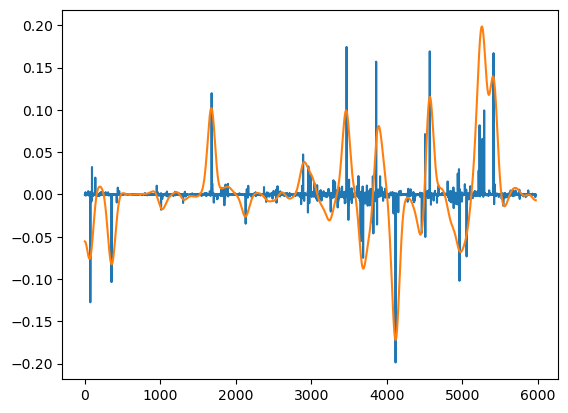

In [31]:
from scipy.ndimage import gaussian_filter1d

xdiff = np.diff(data, axis=1)

xdiff = np.append(xdiff, np.zeros((xdiff.shape[0], 1)), axis=1)

frac_change = xdiff/ data

trend = np.mean(frac_change, axis=0)

# 


smooth_trend = gaussian_filter1d(trend, 50)

plt.plot(trend/np.abs(trend).max() * np.abs(smooth_trend).max())

plt.plot(smooth_trend)